In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df1 = pd.read_csv('trips_2018_cleaned.csv')

In [25]:
save_path = 'figures/'

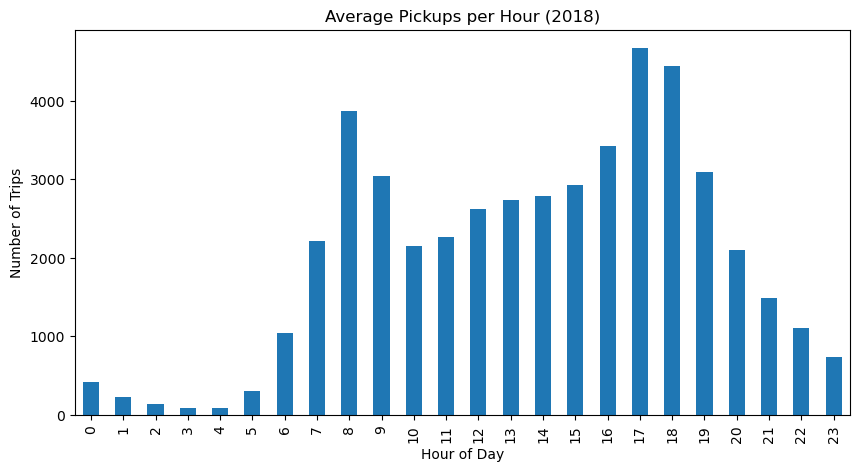

In [26]:
hourly = df1.groupby('hour').size()/len(df1['date'].unique())
plt.figure(figsize=(10,5))
hourly.plot(kind='bar')
plt.title("Average Pickups per Hour (2018)")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.savefig(save_path + 'average_pickups_per_hour_2018.png')
plt.show()

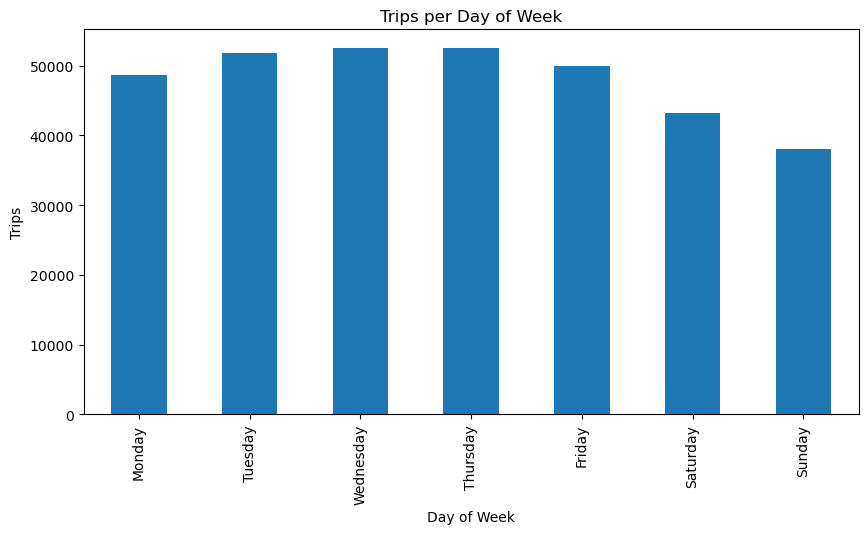

In [27]:
weekly = df1.groupby('day_of_week').size().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)/len(df1["week"].unique())

plt.figure(figsize=(10,5))
weekly.plot(kind='bar')
plt.title("Trips per Day of Week")
plt.ylabel("Trips")
plt.xlabel("Day of Week")
plt.savefig(save_path + 'trips_per_day_of_week.png')
plt.show()


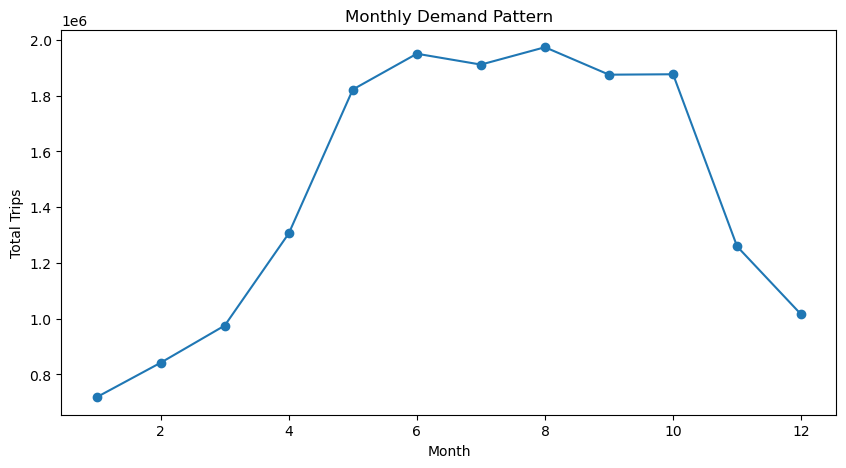

In [28]:
monthly = df1.groupby('month').size()

plt.figure(figsize=(10,5))
monthly.plot(kind='line', marker='o')
plt.title("Monthly Demand Pattern")
plt.xlabel("Month")
plt.ylabel("Total Trips")
plt.savefig(save_path + 'monthly_demand_pattern.png')
plt.show()

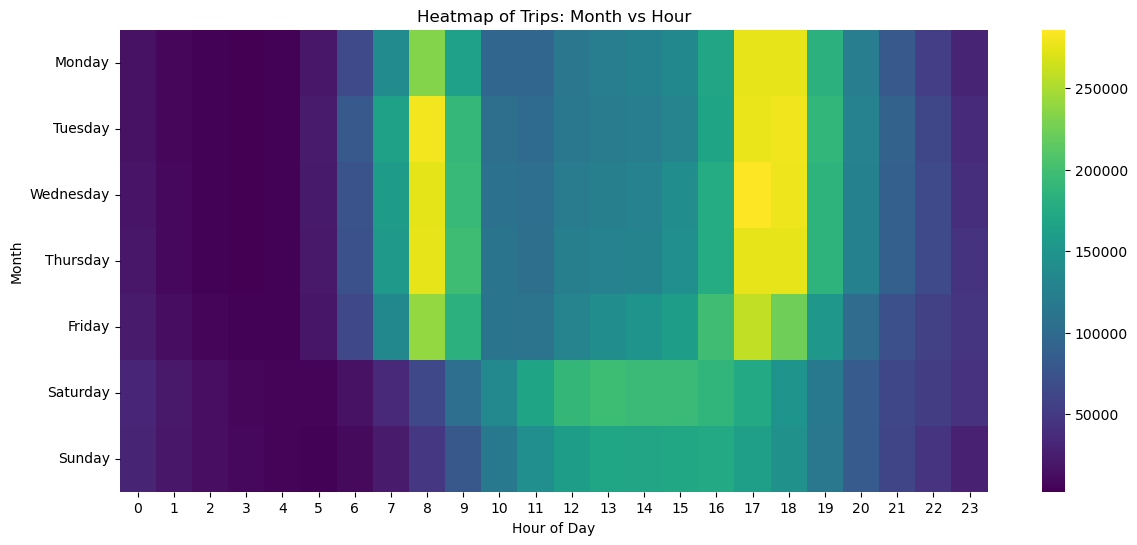

In [29]:
pivot = df1.pivot_table(index='day_of_week', 
                       columns='hour', 
                       values='bikeid', 
                       aggfunc='count')

# Reorder rows
pivot = pivot.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])


plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap="viridis")
plt.title("Heatmap of Trips: Month vs Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Month")
plt.savefig(save_path + 'heatmap_month_hour.png')
plt.show()


In [30]:
df1.tail()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,calculated_duration,date,hour,day_of_week,month,week
17527736,734,2018-12-31 23:55:06.991,2019-01-01 00:07:21.230,336,40.730477,-73.999061,379,40.749156,-73.991600,27111,Subscriber,1986,1,734.239,2018-12-31,23,Monday,12,1
17527737,2551,2018-12-31 23:55:44.307,2019-01-01 00:38:15.782,3320,40.794067,-73.962868,2006,40.765909,-73.976342,16390,Customer,1969,0,2551.475,2018-12-31,23,Monday,12,1
17527738,2376,2018-12-31 23:56:52.850,2019-01-01 00:36:29.286,427,40.701907,-74.013942,259,40.701221,-74.012342,34398,Subscriber,1979,1,2376.436,2018-12-31,23,Monday,12,1
17527739,2758,2018-12-31 23:58:29.212,2019-01-01 00:44:27.517,3320,40.794067,-73.962868,281,40.764397,-73.973715,30818,Customer,1969,0,2758.305,2018-12-31,23,Monday,12,1
17527740,2459,2018-12-31 23:59:51.085,2019-01-01 00:40:50.880,128,40.727103,-74.002971,402,40.740343,-73.989551,34775,Subscriber,1996,2,2459.795,2018-12-31,23,Monday,12,1


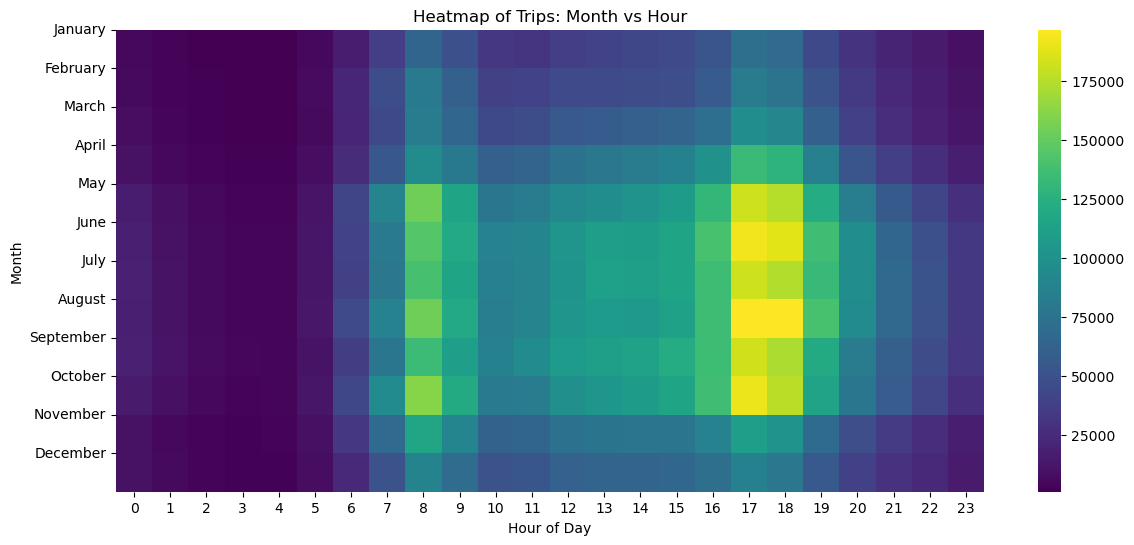

In [31]:
pivot = df1.pivot_table(index='month', 
                       columns='hour', 
                       values='bikeid', 
                       aggfunc='count')

# Reorder rows
month = ["January", "February", "March", "April", "May", "June", 
         "July", "August", "September", "October", "November", "December"]
plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap="viridis")
plt.title("Heatmap of Trips: Month vs Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Month")
plt.yticks(ticks=range(12), labels=month, rotation=0)
plt.savefig(save_path + 'heatmap_month_hour.png')
plt.show()


In [32]:
all_stations = pd.concat([
    df1[['start_station_id', 'start_station_latitude', 'start_station_longitude']],
    df1[['end_station_id', 'end_station_latitude', 'end_station_longitude']].rename(
        columns={'end_station_id': 'start_station_id',
                 'end_station_latitude': 'start_station_latitude',
                 'end_station_longitude': 'start_station_longitude'}
    )
]).drop_duplicates().dropna()

print(f"Total unique stations: {len(all_stations)}")

Total unique stations: 845


In [33]:

lat = all_stations['start_station_latitude'].values
lon = all_stations['start_station_longitude'].values

# Approximate conversion for New York area (40.7°N)
# 1 degree latitude ≈ 111,000 meters
# 1 degree longitude ≈ 85,000 meters (at 40°N latitude)

lat_meters = lat * 111000  # meters
lon_meters = lon * 85000   # meters (adjusted for NYC latitude)

X_meters = np.column_stack([lat_meters, lon_meters])
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=67, n_init=20)
all_stations['cluster'] = kmeans.fit_predict(X_meters)

c:\Users\Ludvig\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [34]:
station_to_cluster = dict(zip(
    all_stations['start_station_id'], 
    all_stations['cluster']
))

# Add to df1
df1['start_cluster'] = df1['start_station_id'].map(station_to_cluster)
df1['end_cluster'] = df1['end_station_id'].map(station_to_cluster)


In [35]:
def aggregate_hourly_demand(df, cluster_id, target='pickups'):
    if target == 'pickups':
        cluster_trips = df[df['start_cluster'] == cluster_id].copy()
    else:
        cluster_trips = df[df['end_cluster'] == cluster_id].copy()
    
    cluster_trips['timestamp'] = pd.to_datetime(cluster_trips['date']) + pd.to_timedelta(cluster_trips['hour'], unit='h')
    hourly_counts = cluster_trips.groupby('timestamp').size().reset_index(name=target)
    hourly_counts = hourly_counts.set_index('timestamp').sort_index()
    
    full_range = pd.date_range(start=hourly_counts.index.min(), end=hourly_counts.index.max(), freq='H')
    hourly_counts = hourly_counts.reindex(full_range, fill_value=0)
    
    return hourly_counts

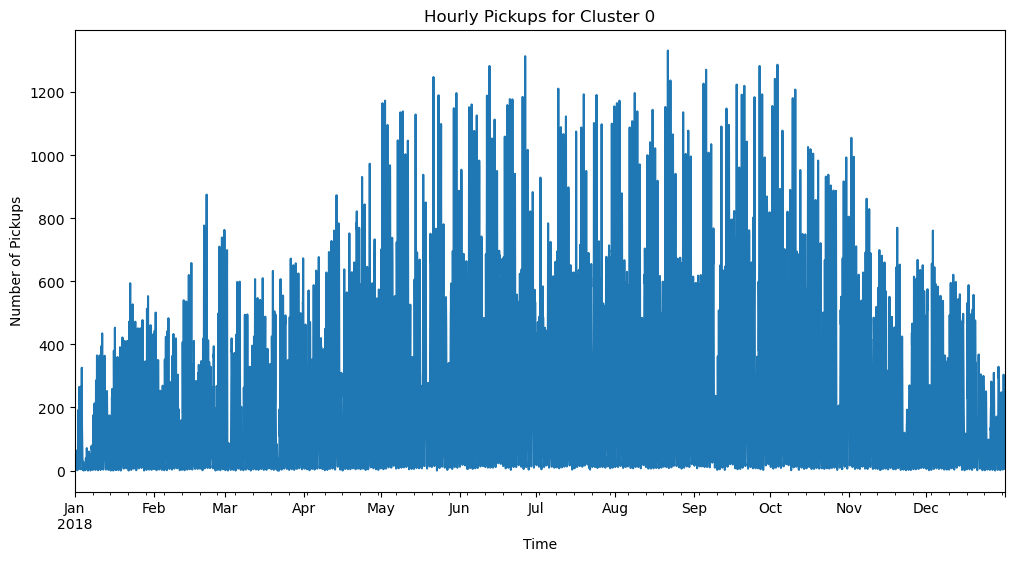

In [36]:
hourly_data = aggregate_hourly_demand(df1, cluster_id=0, target='pickups')
#plot the hourly demand for cluster 0
plt.figure(figsize=(12,6))
hourly_data['pickups'].plot()
plt.title("Hourly Pickups for Cluster 0")
plt.xlabel("Time")
plt.ylabel("Number of Pickups")
plt.savefig(save_path + 'hourly_pickups_cluster_0.png')
plt.show()

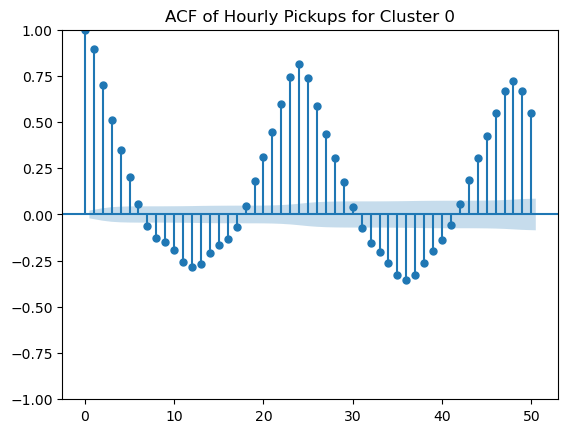

c:\Users\Ludvig\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


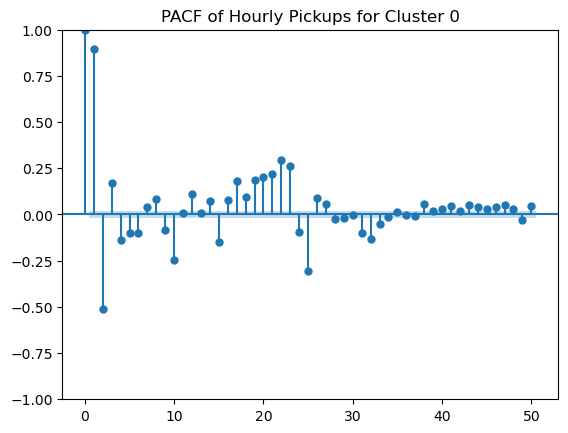

In [37]:
#acf and pacf of the hourly pickups for cluster 0
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(hourly_data['pickups'], lags=50)
plt.title("ACF of Hourly Pickups for Cluster 0")
plt.savefig(save_path + 'acf_hourly_pickups_cluster_0.png')
plt.show()
plot_pacf(hourly_data['pickups'], lags=50)
plt.title("PACF of Hourly Pickups for Cluster 0")
plt.savefig(save_path + 'pacf_hourly_pickups_cluster_0.png')
plt.show()
